In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from qutip import *
from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D

We will create magnetic field disturbance in a random orientation and with random magnitude. Later we will consider Hamiltonians, which depend on the magnetic field strength, and consider how the disturbance affects the dynamic and geometric phases.

We start by generating an arbitrary rotation and magnitude of the disturbance:

In [2]:
def dB(mu_r,sigma_r,mu_f,sigma_f,n):
    
    
    #Create random magnitudes sampled from a Gaussian:
    #We normalise so that the number of samplings does not increase the magnitude of the noise
    
    r = np.random.normal(mu_r, sigma_r, n)/n

    
    #Random frequency drawn from a gaussian:
    omega = np.random.normal(mu_f, sigma_f, n)
    
    
    #Random phase of the magnetic wave:
    phiB = np.random.uniform(0,np.pi*2,n)
    
    
    #Random directions:
    phi = np.random.uniform(0,np.pi*2,n)
    costheta = np.random.uniform(-1,1,n)
        
    theta = np.arccos( costheta )
        
    #Projections:
    xf = np.sin( theta ) * np.cos( phi )*r
    yf = np.sin( theta ) * np.sin( phi )*r
    zf = np.cos( theta )*r

    
    return xf,yf,zf,omega,phiB

We will now create a function, which creates a Hamiltonian based on the magnetic field

In [3]:
def H(Bx,By,Bz):
    
    #Create Pauli matrices:
    
    sx = np.array([[0,1],[1,0]])/2
    sy = np.array([[0,-1.j],[1.j,0]])/2
    sz = np.array([[1,0],[0,-1]])/2
    
    #Create Hamiltonian:
    
    H = -(sx*Bx+sy*By+sz*Bz)
    
    return H
    

We create a dictionary to store all of the important data of for the state:

In [4]:
def psi_dict(psi_val,psi_time):
    #Create dictionary:
    
    
    psi_name = dict();
    
    #Insert the state into dictionary:
    
    psi_name['psi'] = psi_val
    
    #Allocate time steps
    psi_name['t'] = psi_time
    
    #Absolute values of entries:
    
    psi_name['abs'] = np.absolute(psi_val)
    
    #Populations:
    
    psi_name['pop'] = psi_name['abs']**2
    
    psi_name['pop_g'] =psi_name['pop'][:,0]
    
    psi_name['pop_e'] =psi_name['pop'][:,1]
    
    #Phases on entries:
    psi_name['angles'] = np.angle(psi_val)
    
    psi_name['angle_g']=psi_name['angles'][:,0]
    psi_name['angle_e']=psi_name['angles'][:,1]
    
    #Total phase:
    
    phase = []
    
    for i in range(len(psi_val)):
        phase.append(np.angle(np.vdot(psi_val[0],psi_val[i])))
    
    psi_name['theta'] = np.array(phase)
    
    #Geometric phase construction:
    
    #Azimuthal angle intervals:
    #New idea for implementation, where all angles are defined in complex exponentials to avoid problem with 2pi
    
    #Exponential of current phase difference between the two entries (without scaling)
    psi_name['exp_idphi_t'] = psi_val[:,1]*np.conj(psi_val[:,0])
    
    
    #Exponential time retarded by one step (without scaling)
    psi_name['exp_idphi_past'] = np.append(psi_name['exp_idphi_t'][0],psi_name['exp_idphi_t'])[:-1]
    
    
    #Difference in phase relation exponentiated (Scaling not important, since we take the argument)
    psi_name['exp_idphi'] = psi_name['exp_idphi_t']*np.conj(psi_name['exp_idphi_past'])
    
    #Difference in phase relation
    psi_name['dphi'] = np.angle(psi_name['exp_idphi'])
    
    #Change in geometric phase calculated from minus half the area change on the Bloch sphere 
    psi_name['dtheta_geo'] = -1*psi_name['pop_e']*psi_name['dphi']
    
    #Exponetiated geometric phase
    psi_name['exp_theta_geo'] = np.cumprod(np.exp(1.j*psi_name['dtheta_geo']))
    
    #Geometric phase
    psi_name['theta_geo'] = np.angle(psi_name['exp_theta_geo'])
    
    
    #Dynamic phase construction:
    
    psi_name['dpsi'] = np.append([psi_val[0]],psi_val,axis=0)[:-1]-psi_val
    
    dtheta_dyn = []
    
    for i in range(len(psi_val)):
        dtheta_dyn.append(np.imag(np.vdot(psi_val[i],psi_name['dpsi'][i])))
    
    psi_name['dtheta_dyn'] = np.array(dtheta_dyn)
    
    psi_name['theta_dyn'] = -np.cumsum(psi_name['dtheta_dyn'])
    
    
    #Qutip visualisation:
    
    #Change coords to their f****d convention, which deviates from QM!!!
    
    psi_name['z_coord'] = 2*psi_name['pop_g']-1
    
    #Here the first part is sin(theta) given the half angle nature of the Bloch Sphere
    
    psi_name['dphi_t'] = psi_name['angle_e']-psi_name['angle_g']
    
    psi_name['x_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.cos(psi_name['dphi_t'])
    
    psi_name['y_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.sin(psi_name['dphi_t'])
    
    psi_name['b_coord'] = np.array([psi_name['x_coord'],psi_name['y_coord'],psi_name['z_coord']]).T
    
    
    return psi_name

We will now solve for Adiabatic evolution

In [42]:
def Time_evolution_A(psi_0 = [1,0,0],mu_r=0.5,sigma_r=0.01,mu_f=10,sigma_f=5,n=5,T=3,dt_max=0.0001,step_nr=1000,omega_B = 0.1*np.pi,B_amp=10):
    
    #Make psi_0 a complex array
    
    psi_0 = np.array(psi_0).astype('complex128')/np.sqrt(np.vdot(psi_0,psi_0))
    
    #Magnetic noise:

    #Call the noise parameters once:

    x,y,z,omega,phiB = dB(mu_r,sigma_r,mu_f,sigma_f,n)

    #Define the noise as a function of time:

    
    def dB1(t):
        #Create time dependent magnitude
        rt = np.sin(phiB+omega*t)
        #Project onto the random projections and sum all contributions
        xt,yt,zt = np.sum(x*rt),np.sum(y*rt),np.sum(z*rt)
        return xt,yt,zt 

    #Time for one revolution of the magnetic field:
    T_omega_B = 2*np.pi/omega_B

    
    
    def B(t):
        if t < T_omega_B:
            
            Bx = B_amp*np.sin(omega_B*t)
        
            By = B_amp*0
        
            Bz = B_amp*np.cos(omega_B*t)

        else:
            Bx = 0
        
            By = 0
        
            Bz = B_amp
        
        return Bx,By,Bz
    
    
    #Solve the SE equation:
    
    #Create time steps:
    
    steps = T*np.arange(step_nr)/step_nr
    
    #Solve without noise:
    
    def dpsi(t,psi_theta):
        psi = psi_theta[0:2]
        Hamilton = H(B(t)[0],B(t)[1],B(t)[2])
        return np.append(-1.j*Hamilton.dot(psi),[-np.vdot(psi,Hamilton.dot(psi))])
    
    psi_solver =  solve_ivp(dpsi,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    
    psi = psi_dict(psi_solver.y[0:2].T,psi_solver.t)
    
    #Solve with noise:

    def dpsi_n(t,psi_theta):
        psi = psi_theta[0:2]
        Hamilton = H(B(t)[0]+dB1(t)[0],B(t)[1]+dB1(t)[1],B(t)[2]+dB1(t)[2])
        return np.append(-1.j*Hamilton.dot(psi),[-np.vdot(psi,Hamilton.dot(psi))])
        
    psi_n_solver =  solve_ivp(dpsi_n,[0,T],psi_0,max_step=dt_max,t_eval=steps)
    
    
    psi_n = psi_dict(psi_n_solver.y[0:2].T,psi_n_solver.t)


    #Here we create the adiabatic state:

    #Step number where the evolution is complete:

    step_nr_omega_B = int(step_nr*T_omega_B/T)


    psi_a_g = np.concatenate((np.cos(omega_B*steps[0:step_nr_omega_B]/2)*np.exp(1.j*B_amp*steps[0:step_nr_omega_B]/(2)),-np.exp(1.j*B_amp*steps[step_nr_omega_B:]/2)))


    psi_a_e= np.concatenate((np.sin(omega_B*steps[0:step_nr_omega_B]/2)*np.exp(1.j*B_amp*steps[0:step_nr_omega_B]/(2)),np.zeros(step_nr-step_nr_omega_B)))


    psi_a = np.array([psi_a_g,psi_a_e])

    psi_a_info = psi_dict(psi_a.T,steps)

    theta_a_dyn = np.angle(np.exp(1.j*B_amp*steps/2))

    #Fidelity of the states

    F = []

    for i in range(len(psi['t'])):
        F.append(abs(np.vdot(psi['psi'][i],psi_a_info['psi'][i]))**2)

    F = np.array(F)

    F_n = []

    for i in range(len(psi['t'])):
        F_n.append(abs(np.vdot(psi_n['psi'][i],psi_a_info['psi'][i]))**2)

    F_n = np.array(F_n)
    
    return psi, psi_n, np.real(psi_solver.y[2].T), np.real(psi_n_solver.y[2].T), psi_a_info, theta_a_dyn, F, F_n

In [43]:
psi_A,psi_A_n, theta_dyn, theta_n_dyn, psi_a, theta_a_dyn, F, F_n= Time_evolution_A(psi_0=[1,0,0],T=20,B_amp=40,omega_B=2,n=100,mu_r=3,mu_f=100,sigma_f=10,dt_max=0.01,step_nr=100000)

psi_A1,psi_A1_n, theta_dyn1, theta_n_dyn1, psi_a1, theta_a_dyn1, F1, F_n1 = Time_evolution_A(psi_0=[1,0.02,0],T=20,B_amp=40,omega_B=0.5,n=100,mu_r=3,mu_f=10,sigma_f=1,dt_max=0.01,step_nr=100000)

psi_A2,psi_A2_n, theta_dyn2, theta_n_dyn2, psi_a2, theta_a_dyn2, F2, F_n2= Time_evolution_A(psi_0=[1,0,0],T=20,B_amp=40,omega_B=0.5,n=100,mu_r=3,mu_f=100,sigma_f=50,dt_max=0.01,step_nr=100000)

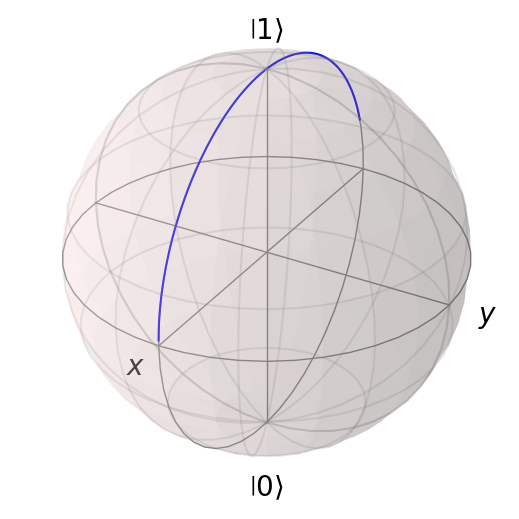

In [57]:
b1 = qutip.Bloch()

b1.make_sphere()

a = 4000

b = 11000

x = psi_a['x_coord'][a:b]

y = psi_a['y_coord'][a:b]

z = -psi_a['z_coord'][a:b]


b1.add_points([x,y,z], meth='l')

b1.zlpos = [-1.4,1.2]

b1.render()

b1.show()

Plot for adiabatic following

In [45]:

def FFT(t, y):
    n = len(t)
    D = (max(t) - min(t)) / (n-1)
    k = int(n/2)
    f = np.arange(k) / (n*D)
    Y = np.abs(np.fft.fft(y))[:k]
    return (f, Y)

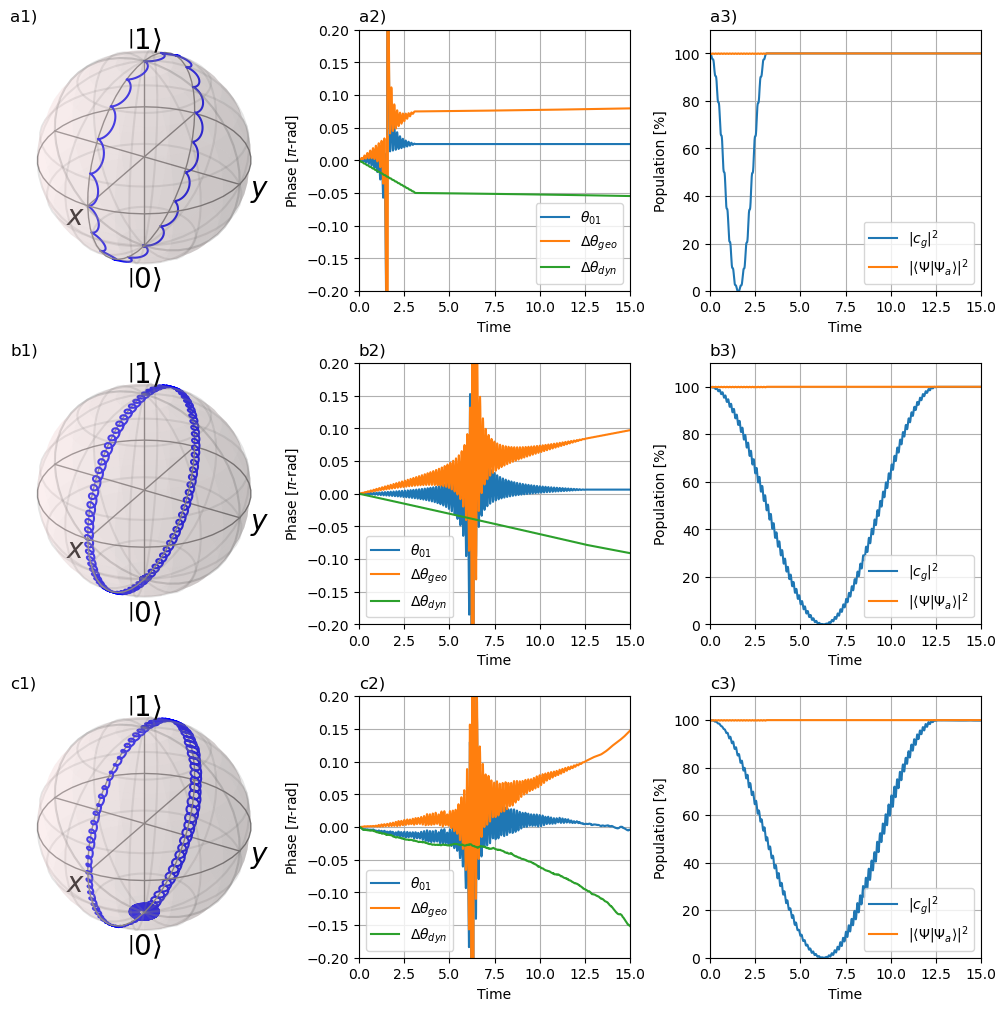

In [51]:
fig = plt.figure(constrained_layout=True,figsize=(10, 10))

ax1 = fig.add_subplot(3,3,1,projection='3d')



b1 = qutip.Bloch(fig=fig, axes=ax1)

b1.make_sphere()



x = psi_A['x_coord']

y = psi_A['y_coord']

z = -psi_A['z_coord']


b1.add_points([x,y,z], meth='l')

b1.zlpos = [-1.4,1.2]

b1.render()

plt.title('a1)',loc='left')



ax2 = fig.add_subplot(3,3,2)



plt.title('a2)',loc='left')

ax2.plot(psi_A['t'],np.angle(np.exp(1.j*(psi_A['theta']-psi_a['theta'])))/np.pi)

theta_geo = psi_A['theta']-theta_dyn

theta_geo_a = psi_a['theta']-theta_a_dyn




ax2.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_geo-theta_geo_a)))/np.pi)

ax2.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_dyn-theta_a_dyn)))/np.pi)

ax2.legend((r'$\theta_{01}$',r'$\Delta\theta_{geo}$',r'$\Delta\theta_{dyn}$'),loc='lower right')


ax2.set_ylim(-0.2,0.2)


ax2.set_xlim(0,15)

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.set_xlabel(r'Time')

ax2.grid()


ax5 = fig.add_subplot(3,3,3)

plt.title('a3)',loc='left')


ax5.plot(psi_A['t'],100*psi_A['pop_g'])


ax5.plot(psi_A['t'],100*F)

ax5.legend((r'$|c_g|^2$',r'$|\langle \Psi|\Psi_a\rangle|^2$'),loc='lower right')

ax5.set_ylim(0,110)


ax5.set_xlim(0,15)

ax5.set_ylabel(r'Population [%]')

ax5.set_xlabel(r'Time')

ax5.grid()


ax3 = fig.add_subplot(3,3,4,projection='3d')



b2 = qutip.Bloch(fig=fig, axes=ax3)

b2.make_sphere()

x2 = psi_A1['x_coord']

y2 = psi_A1['y_coord']

z2 = -psi_A1['z_coord']


b2.add_points([x2,y2,z2], meth='l')

b2.zlpos = [-1.4,1.2]



b2.render()

plt.title('b1)',loc='left')


ax4 = fig.add_subplot(3,3,5)

ax4.plot(psi_A1['t'],np.angle(np.exp(1.j*(psi_A1['angle_g']-psi_a1['theta'])))/np.pi)



ax4.set_ylabel(r'Phase [$\pi$-rad]')

ax4.set_xlabel(r'Time')


theta_geo1 = psi_A1['theta']-theta_dyn1

theta_geo_a1 = psi_a1['theta']-theta_a_dyn1



ax4.plot(psi_A_n['t'],np.angle(np.exp(1.j*(theta_geo1-theta_geo_a1)))/np.pi)

ax4.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_dyn1-theta_a_dyn1)))/np.pi)

ax4.legend((r'$\theta_{01}$',r'$\Delta\theta_{geo}$',r'$\Delta\theta_{dyn}$'),loc='lower left')



ax4.set_ylim(-0.2,0.2)


ax4.set_xlim(0,15)

ax4.grid()

plt.title('b2)',loc='left')


ax6 = fig.add_subplot(3,3,6)

plt.title('b3)',loc='left')


ax6.plot(psi_A1['t'],100*psi_A1['pop_g'])

ax6.plot(psi_A1['t'],100*F)

ax6.set_ylim(0,110)

ax6.set_ylabel(r'Population [%]')

ax6.set_xlabel(r'Time')

ax6.legend((r'$|c_g|^2$',r'$|\langle \Psi|\Psi_a\rangle|^2$'),loc='lower right')
ax6.set_xlim(0,15)

ax6.grid()


#Final row:

ax7 = fig.add_subplot(3,3,7,projection='3d')



b3 = qutip.Bloch(fig=fig, axes=ax7)

b3.make_sphere()

x3 = psi_A2_n['x_coord']

y3 = psi_A2_n['y_coord']

z3 = -psi_A2_n['z_coord']

b3.zlpos = [-1.4,1.2]


b3.add_points([x3,y3,z3], meth='l')

b3.render()

plt.title('c1)',loc='left')


ax8 = fig.add_subplot(3,3,8)

plt.title('c2)',loc='left')

ax8.plot(psi_A2_n['t'],np.angle(np.exp(1.j*(psi_A2_n['theta']-psi_a2['theta'])))/np.pi)

theta_geo_n2 = psi_A2_n['theta']-theta_n_dyn2

theta_geo_a2 = psi_a2['theta']-theta_a_dyn2



ax8.plot(psi_A_n['t'],np.angle(np.exp(1.j*(theta_geo_n2-theta_geo_a2)))/np.pi)

ax8.plot(psi_A['t'],np.angle(np.exp(1.j*(theta_n_dyn2-theta_a_dyn2)))/np.pi)

ax8.legend((r'$\theta_{01}$',r'$\Delta\theta_{geo}$',r'$\Delta\theta_{dyn}$'),loc='lower left')


ax8.set_ylim(-0.2,0.2)


ax8.set_xlim(0,15)

ax8.set_ylabel(r'Phase [$\pi$-rad]')

ax8.set_xlabel(r'Time')

ax8.grid()



ax9 = fig.add_subplot(3,3,9)

plt.title('c3)',loc='left')


ax9.plot(psi_A2_n['t'],100*psi_A2_n['pop_g'])

ax9.plot(psi_A1['t'],100*F)

ax9.set_ylim(0,110)

ax9.set_ylabel(r'Population [%]')

ax9.set_xlabel(r'Time')

ax9.legend((r'$|c_g|^2$',r'$|\langle \Psi|\Psi_a\rangle|^2$'),loc='lower right')
ax9.set_xlim(0,15)

ax9.grid()







plt.savefig('AdiabaticFollowing')

plt.show()





In [10]:

def FFT(t, y):
    n = len(t)
    D = (max(t) - min(t)) / (n-1)
    k = int(n/2)
    f = np.arange(k) / (n*D)
    Y = np.abs(np.fft.fft(y))[:k]
    return (f, Y)

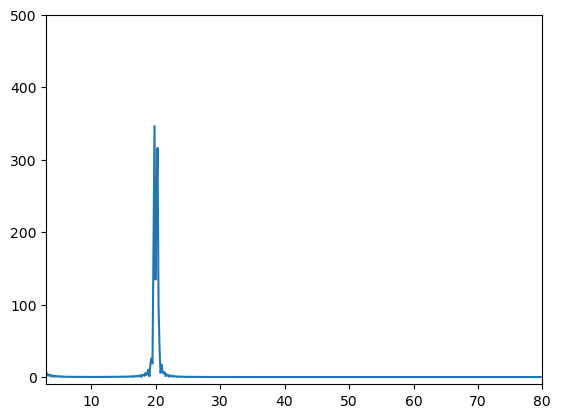

In [63]:

a = 4000

b = 11000

(f,Y)=FFT(psi_A['t'],psi_A1['pop'][:,0])


plt.figure()

plt.plot(f*np.pi,Y)

plt.xlim(3,80)

plt.ylim(-10,500)

#plt.plot(freq,FT.imag)

plt.show()

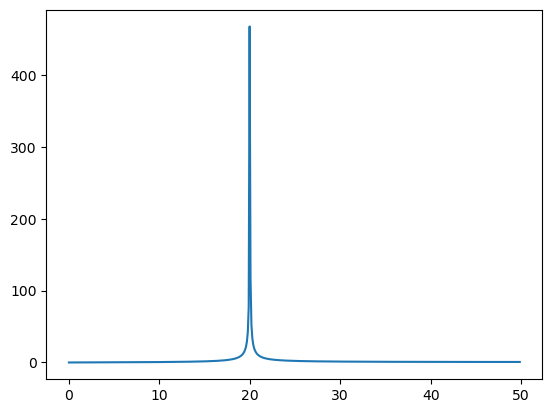

In [12]:
t = np.linspace(0,10,num=1000)

n = 20

sin = np.sin(n*2*np.pi*t)

(f,Y) = FFT(t,sin)

plt.figure()

plt.plot(f,Y)

plt.show()